###**Capturing live video stream from webcam**

<IPython.core.display.Javascript object>

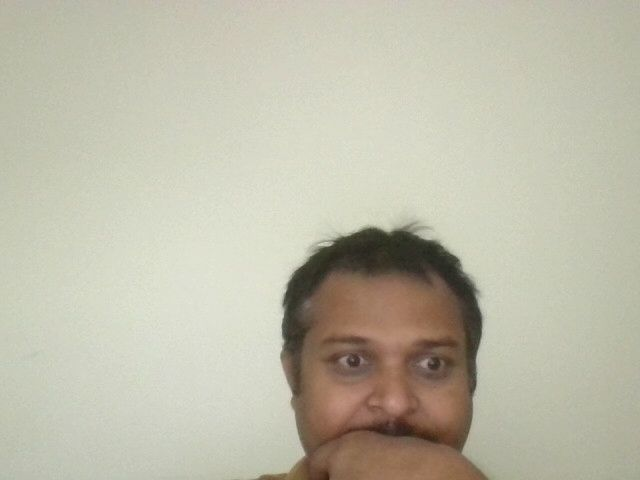

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

# JavaScript code to capture webcam video
def capture_image():
    js = Javascript('''
        async function capture() {
            const div = document.createElement('div');
            const capture = document.createElement('button');
            capture.textContent = 'Capture';
            div.appendChild(capture);

            const video = document.createElement('video');
            video.style.display = 'block';
            div.appendChild(video);

            document.body.appendChild(div);

            const stream = await navigator.mediaDevices.getUserMedia({video: true});
            video.srcObject = stream;
            await video.play();

            // Resize the output to the video size
            google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

            // Wait for Capture to be clicked
            await new Promise((resolve) => capture.onclick = resolve);

            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            canvas.getContext('2d').drawImage(video, 0, 0);
            stream.getTracks().forEach(track => track.stop());
            div.remove();

            return canvas.toDataURL('image/jpeg', 0.8);
        }
        capture();
    ''')
    display(js)
    data = eval_js('capture()')
    binary = b64decode(data.split(',')[1])
    return binary

# Capture and convert to OpenCV image
img_bytes = capture_image()
img_array = np.frombuffer(img_bytes, dtype=np.uint8)
frame = cv2.imdecode(img_array, cv2.IMREAD_COLOR)

# Show image using cv2_imshow
cv2_imshow(frame)


In [ ]:
from keras.models import model_from_json

# Upload files
from google.colab import files
uploaded = files.upload()

# Load model architecture
with open('emotiondetector.json', 'r') as json_file:
    model_json = json_file.read()
model = model_from_json(model_json)

# Load weights
model.load_weights('emotiondetector.h5')
print("Model loaded successfully.")


KeyboardInterrupt: 

In [ ]:
emotion_labels = ['Happy', 'lovely']

def preprocess_frame(frame):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)

    for (x, y, w, h) in faces:
        face = gray[y:y+h, x:x+w]
        face = cv2.resize(face, (48, 48))
        face = face.astype("float") / 255.0
        face = np.expand_dims(face, axis=-1) # adds channel info
        face = np.expand_dims(face, axis=0) # adds batch info

        preds = model.predict(face)
        emotion = emotion_labels[np.argmax(preds)]

        # Draw label and bounding box
        cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
        cv2.putText(frame, emotion, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)

    return frame


<IPython.core.display.Javascript object>

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


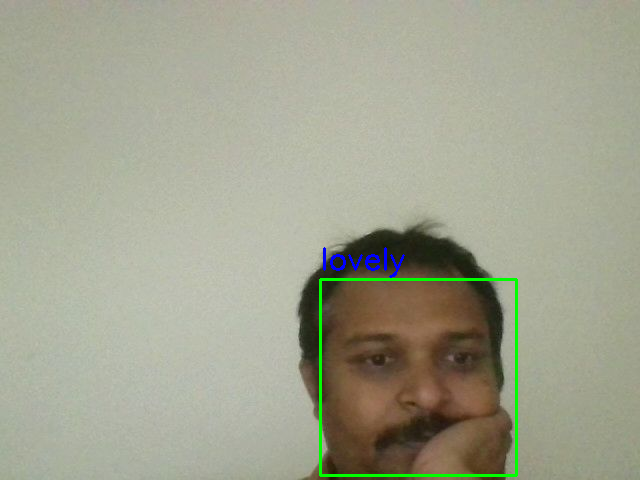

In [ ]:
# Capture and convert to OpenCV image
img_bytes = capture_image()
img_array = np.frombuffer(img_bytes, dtype=np.uint8)
frame = cv2.imdecode(img_array, cv2.IMREAD_COLOR)

# Detect emotion and display
processed_frame = preprocess_frame(frame)
cv2_imshow(processed_frame)
